In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import re

pd.set_option('display.max_columns', None)   # 모든 컬럼 표시
pd.set_option('display.width', None)         # 줄바꿈 없이 전체 폭 사용
pd.set_option('display.max_colwidth', None)  # 컬럼 내용 생략 안 함

df_raw  = pd.read_csv('data/steam_review_with_gameinfo.csv')
df = df_raw.copy()
df.head()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10760\554531869.py:23: DtypeWarning: Columns (24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw  = pd.read_csv('data/steam_review_with_gameinfo.csv')


,Unnamed: 0.1,Unnamed: 0,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck,required_age,price,metacritic_score,achievements,supported_languages,user_score,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,genre,price_missing,metacritic_missing,user_score_missing,pct_pos_recent_missing
0,0,0,1049590,215253495,76561199088477441,0,1,110791.0,2184.0,110700.0,NaN,1.767647e+09,koreana,재밌는거 같기도 하고 아닌거 같기도하고\n일단 좀만 더 해봐야 알듯???/,1767643238,1767643238,True,0,0,0.5,0,False,False,False,NaN,NaN,False,0.0,FREE,87.0,0.0,"English * , Japanese * , Simplified Chinese, Korean * , Traditional Chinese, French, German, Spanish - Spain, Portuguese - Portugal, Spanish - Latin America, Russian, Thai, Vietnamese, Portuguese - Brazil * languages with full audio support",81.308411,81.308411,107,81.308411,107,"['Indie', 'Strategy', 'Free To Play']",0,1,0,0
1,1,1,1049590,215244780,76561199111467010,0,1,150415.0,3971.0,150415.0,NaN,1.767541e+09,koreana,*롤대비 스트레스가 적음.\r\n*근데 운도 좀 많이 따름 좃같 ㅋㅋㅋ\r\n*그래도 롤대비 판당 회전수가 빠르고. 결과가 빨리 나옴. 재밋음,1767636755,1767636755,True,0,0,0.5,0,False,False,False,NaN,NaN,False,0.0,FREE,87.0,0.0,"English * , Japanese * , Simplified Chinese, Korean * , Traditional Chinese, French, German, Spanish - Spain, Portuguese - Portugal, Spanish - Latin America, Russian, Thai, Vietnamese, Portuguese - Brazil * languages with full audio support",81.308411,81.308411,107,81.308411,107,"['Indie', 'Strategy', 'Free To Play']",0,1,0,0
2,2,2,1049590,215236053,76561198053918088,250,29,4731.0,4731.0,4584.0,NaN,1.767639e+09,japanese,LoLやDOTA2をプレイするよりはカジュアルに出来るが、たまに飛んでくる罵詈雑言が丁寧に翻訳されるのでそれをレポートしてプレイヤー通報するのも楽しみの一つ。\n中国人じゃないのに「中国の犬(china dog)」だとか「kys＝キルユアセルフ（自〇しろだとか、４んでこいというネットスラングみたいです」本来伏字になるんですけど、ご丁寧に１文字ずつ打ってくれるんで通報の材料くれて助かる。ポリシー違反で措置されましたと通知が飛んでくるので仕事が出来る運営だと思います。\n翻訳機能があるおかげで通報が楽なのはいいですね。\n韓国人から見たら名前が漢字だけだと中国人と勘違いするんでしょうね。\nこのゲーム30レベルからじゃないとランクマッチ解禁されないんでサブ垢で罵詈雑言言いまくってる害悪なんでしょうね。,1767630260,1767630260,True,0,0,0.5,0,False,False,False,NaN,NaN,False,0.0,FREE,87.0,0.0,"English * , Japanese * , Simplified Chinese, Korean * , Traditional Chinese, French, German, Spanish - Spain, Portuguese - Portugal, Spanish - Latin America, Russian, Thai, Vietnamese, Portuguese - Brazil * languages with full audio support",81.308411,81.308411,107,81.308411,107,"['Indie', 'Strategy', 'Free To Play']",0,1,0,0
3,3,3,1049590,215234263,76561199082041003,0,4,31541.0,1621.0,31541.0,NaN,1.767624e+09,koreana,내가 이리를 키게 하려면 롤 증바람부터 이기고 와라,1767628939,1767629322,True,0,0,0.5,0,False,False,False,NaN,NaN,False,0.0,FREE,87.0,0.0,"English * , Japanese * , Simplified Chinese, Korean * , Traditional Chinese, French, German, Spanish - Spain, Portuguese - Portugal, Spanish - Latin America, Russian, Thai, Vietnamese, Portuguese - Brazil * languages with full audio support",81.308411,81.308411,107,81.308411,107,"['Indie', 'Strategy', 'Free To Play']",0,1,0,0
4,4,4,1049590,215231231,76561199072083040,0,1,43106.0,1808.0,43067.0,NaN,1.767628e+09,koreana,abcdefg알파벳놀이 즐거워요,1767626666,1767626666,False,0,0,0.5,0,False,False,False,NaN,NaN,False,0.0,FREE,87.0,0.0,"English * , Japanese * , Simplified Chinese, Korean * , Traditional Chinese, French, German, Spanish - Spain, Portuguese - Portugal, Spanish - Latin America, Russian, Thai, Vietnamese, Portuguese - Brazil * languages with full audio support",81.308411,81.308411,107,81.308411,107,"['Indie', 'Strategy', 'Free To Play']",0,1,0,0


| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 | 

In [198]:
# 데이터셋 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940051 entries, 0 to 1940050
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0.1                 int64  
 1   Unnamed: 0                   int64  
 2   appid                        int64  
 3   recommendationid             int64  
 4   steamid                      int64  
 5   num_games_owned              int64  
 6   num_reviews_author           int64  
 7   playtime_forever             float64
 8   playtime_last_two_weeks      float64
 9   playtime_at_review           float64
 10  deck_playtime_at_review      float64
 11  last_played                  float64
 12  language                     object 
 13  review                       object 
 14  timestamp_created            int64  
 15  timestamp_updated            int64  
 16  voted_up                     bool   
 17  votes_up                     int64  
 18  votes_funny                  int64  
 19  

In [199]:
# 결측치 확인
df.isnull().sum()

Unnamed: 0.1                         0
Unnamed: 0                           0
appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                    12
playtime_last_two_weeks             12
playtime_at_review                 786
deck_playtime_at_review        1906842
last_played                         12
language                             0
review                            6398
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             1935805
timestamp_dev_responded  

In [200]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,timestamp_dev_responded,required_age,metacritic_score,achievements,user_score,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,price_missing,metacritic_missing,user_score_missing,pct_pos_recent_missing
count,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940039e+06,1.940039e+06,1.939265e+06,33209.000000,1.940039e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,4.246000e+03,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06,1.940051e+06
mean,9.700250e+05,9.700250e+05,2.096539e+06,2.082557e+08,7.656120e+16,7.527263e+01,1.133371e+01,9.647863e+03,4.578581e+02,7.394106e+03,1417.730284,1.762893e+09,1.761445e+09,1.761594e+09,7.523931e-01,1.409741e-01,5.027250e-01,5.348468e-02,1.759518e+09,4.351092e+00,8.649910e+01,5.384367e+01,8.371776e+01,8.371776e+01,3.651957e+05,8.371785e+01,3.651968e+05,3.809178e-04,5.177678e-01,5.996492e-02,5.996492e-02
std,5.600446e+05,5.600446e+05,1.144168e+06,4.525632e+06,6.191312e+08,2.551241e+02,7.295717e+01,2.535061e+04,1.139248e+03,2.357699e+04,4515.268571,3.659263e+07,4.373171e+06,4.352274e+06,2.262111e+01,4.521929e+00,2.285303e-02,1.049386e+00,4.546430e+06,7.232807e+00,3.205605e+00,5.129030e+01,1.434508e+01,1.434508e+01,5.525429e+05,1.434512e+01,5.525424e+05,1.951340e-02,4.996843e-01,2.374219e-01,2.374219e-01
min,0.000000e+00,0.000000e+00,4.400000e+02,1.994023e+08,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000,0.000000e+00,1.752096e+09,1.752096e+09,0.000000e+00,0.000000e+00,7.237145e-02,0.000000e+00,1.752181e+09,0.000000e+00,6.900000e+01,0.000000e+00,3.057250e+01,3.057250e+01,0.000000e+00,3.057250e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.850125e+05,4.850125e+05,1.142710e+06,2.046684e+08,7.656120e+16,0.000000e+00,2.000000e+00,1.097000e+03,0.000000e+00,5.590000e+02,46.000000,1.763098e+09,1.758253e+09,1.758499e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.755116e+09,0.000000e+00,8.600000e+01,3.700000e+01,7.129425e+01,7.129425e+01,8.226900e+04,7.129425e+01,8.226900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.700250e+05,9.700250e+05,2.444750e+06,2.087446e+08,7.656120e+16,0.000000e+00,4.000000e+00,3.206000e+03,0.000000e+00,1.679000e+03,253.000000,1.765792e+09,1.762632e+09,1.763016e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.759782e+09,0.000000e+00,8.700000e+01,5.000000e+01,8.968451e+01,8.968451e+01,2.219280e+05,8.968451e+01,2.219280e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.455038e+06,1.455038e+06,3.059520e+06,2.118270e+08,7.656120e+16,7.300000e+01,1.000000e+01,8.340000e+03,3.360000e+02,5.124000e+03,992.000000,1.767234e+09,1.764488e+09,1.764526e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.763499e+09,1.300000e+01,8.700000e+01,5.400000e+01,9.504299e+01,9.504299e+01,2.744450e+05,9.504299e+01,2.744450e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.940050e+06,1.940050e+06,4.077430e+06,2.152632e+08,7.656120e+16,3.816800e+04,1.974800e+04,2.457680e+06,3.460800e+04,2.416117e+06,157407.000000,1.767652e+09,1.767650e+09,1.767651e+09,1.739100e+04,3.277000e+03,9.943360e-01,5.110000e+02,1.767650e+09,1.800000e+01,9.600000e+01,5.200000e+02,9.850777e+01,9.850777e+01,4.859224e+06,9.850777e+01,4.859224e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [201]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'appid', 'recommendationid', 'steamid',
       'num_games_owned', 'num_reviews_author', 'playtime_forever',
       'playtime_last_two_weeks', 'playtime_at_review',
       'deck_playtime_at_review', 'last_played', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'developer_response', 'timestamp_dev_responded', 'primarily_steam_deck',
       'required_age', 'price', 'metacritic_score', 'achievements',
       'supported_languages', 'user_score', 'pct_pos_total',
       'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent', 'genre',
       'price_missing', 'metacritic_missing', 'user_score_missing',
       'pct_pos_recent_missing'],
      dtype='object')

In [202]:
df.count()

Unnamed: 0.1                   1940051
Unnamed: 0                     1940051
appid                          1940051
recommendationid               1940051
steamid                        1940051
num_games_owned                1940051
num_reviews_author             1940051
playtime_forever               1940039
playtime_last_two_weeks        1940039
playtime_at_review             1939265
deck_playtime_at_review          33209
last_played                    1940039
language                       1940051
review                         1933653
timestamp_created              1940051
timestamp_updated              1940051
voted_up                       1940051
votes_up                       1940051
votes_funny                    1940051
weighted_vote_score            1940051
comment_count                  1940051
steam_purchase                 1940051
received_for_free              1940051
written_during_early_access    1940051
developer_response                4246
timestamp_dev_responded  

In [203]:

# 1. ROC-AUC 점수 확인을 위한 기본 전처리

df = df.copy()

df["review_dt"] = pd.to_datetime(df["timestamp_created"], unit="s", errors="coerce")
df = df.dropna(subset=["review_dt"]).copy()

# deck_playtime_at_review 결측 처리 (컬럼 있으면)
if "deck_playtime_at_review" in df.columns:
    df["deck_playtime_at_review"] = df["deck_playtime_at_review"].fillna(0)

# True/False -> 0/1 정리 (LightGBM 용)
bool_cols = [
    "primarily_steam_deck",
    "voted_up",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
]
for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].astype(int)


In [204]:

# 2. 180일 중 마지막 60일 제외

# 마지막 60일은 미래 정보에 해당하므로 라벨 생성에서 제외
# 과거 120일 구간만 사용해 학습용 라벨을 안정적으로 정의
END_DATE = df["review_dt"].max()
START_DATE = END_DATE - pd.Timedelta(days=180)
LABEL_CUTOFF = END_DATE - pd.Timedelta(days=60)

# 최근 180일 AND cutoff까지(=120일)만
df_label = df[(df["review_dt"] >= START_DATE) & (df["review_dt"] <= LABEL_CUTOFF)].copy()

### 해당 프로젝트는 리뷰 시점을 기준으로 이탈을 예측하는 문제로 정의했습니다.
### 따라서 리뷰 이후의 행동만을 기준으로 타겟을 정의하여 예측 시점과 라벨 시점이 섞이는 데이터 누수를 방지했습니다.
### 데이터 수집 오류로 인해 리뷰 이전 시점의 last_played가 존재하는 경우는
### 정상적인 복귀로 해석할 수 없기 때문에 이탈로 보수적으로 처리했습니다.

In [205]:
# # 3. churn 생성
# df_label["last_played_dt"] = pd.to_datetime(df_label["last_played"], unit="s", errors="coerce")

# # last_played가 Null이면 복귀 관측 안돼서 churn=1 처리
# df_label["churn"] = (
#     df_label["last_played_dt"].isna() | (df_label["last_played_dt"] <= (df_label["review_dt"] + pd.Timedelta(days=30)))
# ).astype(int)

In [206]:
# 3. churn 생성

review_dt = df_label["review_dt"]
last_dt   = pd.to_datetime(df_label["last_played"], unit="s")

df_label["days_after_review"] = (last_dt - review_dt).dt.days

df_label["churn"] = (df_label["days_after_review"] < 30).astype(int)

# 예외 처리
df_label.loc[df_label["last_played"] == 0, "churn"] = 1
df_label.loc[df_label["days_after_review"] < 0, "churn"] = 1


# 분포 확인
print(df_label["churn"].value_counts(dropna=False))
print("이탈률(%) =", round(df_label["churn"].mean() * 100, 2))
df_label[["timestamp_created","last_played","days_after_review","churn"]].head(5)

churn
0    636448
1    314743
Name: count, dtype: int64
이탈률(%) = 33.09


,timestamp_created,last_played,days_after_review,churn
1142,1762449767,1.764871e+09,28.0,1
1143,1762448068,1.761762e+09,-8.0,1
1144,1762446920,1.761968e+09,-6.0,1
1145,1762446476,1.767635e+09,60.0,0
1146,1762439442,1.767644e+09,60.0,0


In [207]:

# 4. 피처 선택 (도메인 기반 필터)
features = [
    "num_games_owned",
    "num_reviews_author",
    "deck_playtime_at_review",
    "voted_up",
    "votes_up",
    "votes_funny",
    "weighted_vote_score",
    "comment_count",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
    "review_length",
    "required_age",
    "price",
    "metacritic_score",
    "achievements",
    #"supported_languages",
    "user_score",
    "pct_pos_total",
    "num_reviews_total",
    "pct_pos_recent",
    "num_reviews_recent",
    #"genre",
    "price_missing",
    "metacritic_missing",
    "user_score_missing",
    "pct_pos_recent_missing"
]

# 존재하는 컬럼만 사용 (실행 에러 방지)
features = [c for c in features if c in df_label.columns]

# 숫자형 강제 (문자 섞이면 터짐)
for c in features:
    df_label[c] = pd.to_numeric(df_label[c], errors="coerce")

# 결측은 0으로 채움
X = df_label[features].fillna(0)
y = df_label["churn"].astype(int)


In [208]:
# 5. 시간 기준 Train/Valid Split (마지막 30일을 valid)
# df_label 기준 마지막 30일
split_date = df_label["review_dt"].max() - pd.Timedelta(days=30)

train_mask = df_label["review_dt"] <= split_date
valid_mask = df_label["review_dt"] > split_date

# 인덱스 안전하게
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[valid_mask], y.loc[valid_mask]

print("Rows:", len(df_label), "| Train:", len(X_train), "| Valid:", len(X_test))
print("Churn rate train:", round(y_train.mean(), 4), "| valid:", round(y_test.mean(), 4))
print("Features used:", features)

if y_test.nunique() < 2:
    raise ValueError(f"Valid set에 클래스가 1개뿐입니다. (unique={y_test.unique()}) split_date를 조정하거나 기간을 늘려야 합니다.")

Rows: 951191 | Train: 595560 | Valid: 355631
Churn rate train: 0.3274 | valid: 0.3367
Features used: ['num_games_owned', 'num_reviews_author', 'deck_playtime_at_review', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'required_age', 'price', 'metacritic_score', 'achievements', 'user_score', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent', 'price_missing', 'metacritic_missing', 'user_score_missing', 'pct_pos_recent_missing']


In [209]:
# 6. LightGBM 학습 + ROC-AUC
model = LGBMClassifier(
    objective="binary",
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc"
)

pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, pred)
print(f"Validation ROC-AUC: {auc:.4f}")

[LightGBM] [Info] Number of positive: 194993, number of negative: 400567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 595560, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327411 -> initscore=-0.719917
[LightGBM] [Info] Start training from score -0.719917
Validation ROC-AUC: 0.6721


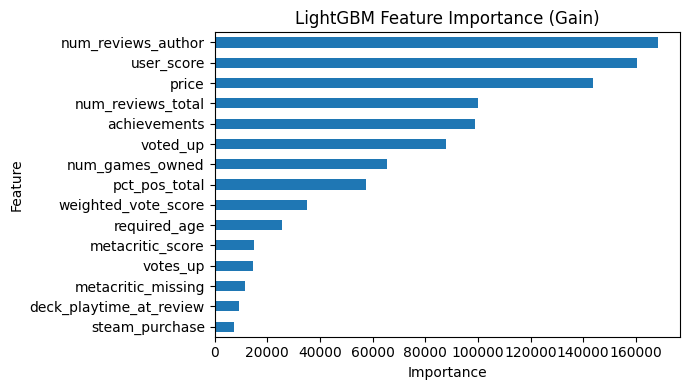

num_reviews_author             168342.483615
user_score                     160311.487311
price                          143871.816144
num_reviews_total               99880.162214
achievements                    98816.082432
voted_up                        88013.180337
num_games_owned                 65470.780478
pct_pos_total                   57374.726347
weighted_vote_score             35291.511436
required_age                    25534.878585
metacritic_score                15116.057058
votes_up                        14740.149081
metacritic_missing              11432.220359
deck_playtime_at_review          9481.706965
steam_purchase                   7357.406101
votes_funny                      7236.599896
num_reviews_recent               7004.642332
pct_pos_recent                   6918.318868
comment_count                    4225.013499
written_during_early_access      3458.402083
received_for_free                2097.929958
user_score_missing                565.535834
pct_pos_re

In [210]:
import matplotlib.pyplot as plt
import pandas as pd

# feature importance (gain)
imp = pd.Series(
    model.booster_.feature_importance(importance_type="gain"),
    index=features
).sort_values(ascending=False)

# 상위 15개 시각화
top_n = 15
imp.head(top_n).iloc[::-1].plot(
    kind="barh",
    figsize=(7, 4)
)

plt.title("LightGBM Feature Importance (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
print(imp)


## AUC-ROC 점수가 유의미한 점수라고 판단 해당 데이터셋 선택 최종 확정

## EDA

In [211]:
# 다시 새 데이터셋
df = df_raw.copy()

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940051 entries, 0 to 1940050
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0.1                 int64  
 1   Unnamed: 0                   int64  
 2   appid                        int64  
 3   recommendationid             int64  
 4   steamid                      int64  
 5   num_games_owned              int64  
 6   num_reviews_author           int64  
 7   playtime_forever             float64
 8   playtime_last_two_weeks      float64
 9   playtime_at_review           float64
 10  deck_playtime_at_review      float64
 11  last_played                  float64
 12  language                     object 
 13  review                       object 
 14  timestamp_created            int64  
 15  timestamp_updated            int64  
 16  voted_up                     bool   
 17  votes_up                     int64  
 18  votes_funny                  int64  
 19  

In [213]:
df.isnull().sum()

Unnamed: 0.1                         0
Unnamed: 0                           0
appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                    12
playtime_last_two_weeks             12
playtime_at_review                 786
deck_playtime_at_review        1906842
last_played                         12
language                             0
review                            6398
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             1935805
timestamp_dev_responded  

In [214]:
# 결측치 제거
df.drop(columns=['developer_response','timestamp_dev_responded'],inplace=True)
df = df.dropna(subset=['review','playtime_last_two_weeks','playtime_forever','last_played'])
df.isnull().sum()

Unnamed: 0.1                         0
Unnamed: 0                           0
appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                     0
playtime_last_two_weeks              0
playtime_at_review                 786
deck_playtime_at_review        1900517
last_played                          0
language                             0
review                               0
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
primarily_steam_deck                 0
required_age             

In [215]:
# 이상치
df.describe()

,Unnamed: 0.1,Unnamed: 0,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,required_age,metacritic_score,achievements,user_score,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,price_missing,metacritic_missing,user_score_missing,pct_pos_recent_missing
count,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.932855e+06,33124.000000,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06
mean,9.699565e+05,9.699565e+05,2.096876e+06,2.082561e+08,7.656120e+16,7.534153e+01,1.132921e+01,9.654224e+03,4.577669e+02,7.400640e+03,1419.782242,1.762889e+09,1.761445e+09,1.761595e+09,7.546996e-01,1.413954e-01,5.027369e-01,5.365939e-02,4.350502e+00,8.649908e+01,5.383933e+01,8.371760e+01,8.371760e+01,3.652173e+05,8.371768e+01,3.652185e+05,3.806291e-04,5.179105e-01,5.997597e-02,5.997597e-02
std,5.599853e+05,5.599853e+05,1.144232e+06,4.524973e+06,6.191176e+08,2.553675e+02,7.305081e+01,2.537015e+04,1.139233e+03,2.359601e+04,4520.339683,3.665148e+07,4.372581e+06,4.351631e+06,2.265853e+01,4.529406e+00,2.288376e-02,1.051119e+00,7.232351e+00,3.204824e+00,5.130115e+01,1.434697e+01,1.434697e+01,5.526716e+05,1.434701e+01,5.526711e+05,1.950601e-02,4.996792e-01,2.374424e-01,2.374424e-01
min,0.000000e+00,0.000000e+00,4.400000e+02,1.994023e+08,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000,0.000000e+00,1.752096e+09,1.752096e+09,0.000000e+00,0.000000e+00,7.237145e-02,0.000000e+00,0.000000e+00,6.900000e+01,0.000000e+00,3.057250e+01,3.057250e+01,0.000000e+00,3.057250e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.850610e+05,4.850610e+05,1.142710e+06,2.046702e+08,7.656120e+16,0.000000e+00,2.000000e+00,1.097000e+03,0.000000e+00,5.590000e+02,46.000000,1.763097e+09,1.758255e+09,1.758502e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.600000e+01,3.700000e+01,7.129425e+01,7.129425e+01,8.226900e+04,7.129425e+01,8.226900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.698530e+05,9.698530e+05,2.444750e+06,2.087465e+08,7.656120e+16,0.000000e+00,4.000000e+00,3.207000e+03,0.000000e+00,1.680000e+03,254.000000,1.765791e+09,1.762634e+09,1.763022e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.700000e+01,5.000000e+01,8.968451e+01,8.968451e+01,2.219280e+05,8.968451e+01,2.219280e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.454988e+06,1.454988e+06,3.059520e+06,2.118259e+08,7.656120e+16,7.300000e+01,1.000000e+01,8.343000e+03,3.360000e+02,5.128000e+03,994.000000,1.767234e+09,1.764488e+09,1.764526e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.300000e+01,8.700000e+01,5.400000e+01,9.504299e+01,9.504299e+01,2.744450e+05,9.504299e+01,2.744450e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.940050e+06,1.940050e+06,4.077430e+06,2.152632e+08,7.656120e+16,3.816800e+04,1.974800e+04,2.457680e+06,3.460800e+04,2.416117e+06,157407.000000,1.767652e+09,1.767650e+09,1.767651e+09,1.739100e+04,3.277000e+03,9.943360e-01,5.110000e+02,1.800000e+01,9.600000e+01,5.200000e+02,9.850777e+01,9.850777e+01,4.859224e+06,9.850777e+01,4.859224e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [216]:
# 플레 시간 관련 컬럼들이 말도 안되는 초헤비 유저 > 봇사용 의심 + 영향력 
# 1. 상위 99.9% 캡 
cap = df["playtime_forever"].quantile(0.999)

# 2. 캡 + log1p 처리해서 바로 덮어쓰기
df["playtime_forever"] = np.log1p(
    df["playtime_forever"].clip(upper=cap)
)

# playtime_forever은 시간 누수가 있어서 피쳐로는 사용 안하지만 플레이시간을 제거함으로써 다른 시간 이상치를 같이 처리 해주었다

In [217]:
# num_games_owned
# median: 0
# 75%: 51
# max: 33,700
# std: 197
cap = df["num_games_owned"].quantile(0.999)
df["num_games_owned"] = np.log1p(df["num_games_owned"].clip(upper=cap))

In [218]:
# num_reviews_author
# median: 3
# 75%: 8
# max: 19,748
cap = df["num_reviews_author"].quantile(0.999)
df["num_reviews_author"] = np.log1p(df["num_reviews_author"].clip(upper=cap))

In [219]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,required_age,metacritic_score,achievements,user_score,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,price_missing,metacritic_missing,user_score_missing,pct_pos_recent_missing
count,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.932855e+06,33124.000000,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06,1.933641e+06
mean,9.699565e+05,9.699565e+05,2.096876e+06,2.082561e+08,7.656120e+16,2.065351e+00,1.810924e+00,8.013228e+00,4.577669e+02,7.400640e+03,1419.782242,1.762889e+09,1.761445e+09,1.761595e+09,7.546996e-01,1.413954e-01,5.027369e-01,5.365939e-02,4.350502e+00,8.649908e+01,5.383933e+01,8.371760e+01,8.371760e+01,3.652173e+05,8.371768e+01,3.652185e+05,3.806291e-04,5.179105e-01,5.997597e-02,5.997597e-02
std,5.599853e+05,5.599853e+05,1.144232e+06,4.524973e+06,6.191176e+08,2.319551e+00,9.999333e-01,1.569132e+00,1.139233e+03,2.359601e+04,4520.339683,3.665148e+07,4.372581e+06,4.351631e+06,2.265853e+01,4.529406e+00,2.288376e-02,1.051119e+00,7.232351e+00,3.204824e+00,5.130115e+01,1.434697e+01,1.434697e+01,5.526716e+05,1.434701e+01,5.526711e+05,1.950601e-02,4.996792e-01,2.374424e-01,2.374424e-01
min,0.000000e+00,0.000000e+00,4.400000e+02,1.994023e+08,7.656120e+16,0.000000e+00,6.931472e-01,0.000000e+00,0.000000e+00,5.000000e+00,1.000000,0.000000e+00,1.752096e+09,1.752096e+09,0.000000e+00,0.000000e+00,7.237145e-02,0.000000e+00,0.000000e+00,6.900000e+01,0.000000e+00,3.057250e+01,3.057250e+01,0.000000e+00,3.057250e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.850610e+05,4.850610e+05,1.142710e+06,2.046702e+08,7.656120e+16,0.000000e+00,1.098612e+00,7.001246e+00,0.000000e+00,5.590000e+02,46.000000,1.763097e+09,1.758255e+09,1.758502e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.600000e+01,3.700000e+01,7.129425e+01,7.129425e+01,8.226900e+04,7.129425e+01,8.226900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.698530e+05,9.698530e+05,2.444750e+06,2.087465e+08,7.656120e+16,0.000000e+00,1.609438e+00,8.073403e+00,0.000000e+00,1.680000e+03,254.000000,1.765791e+09,1.762634e+09,1.763022e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.700000e+01,5.000000e+01,8.968451e+01,8.968451e+01,2.219280e+05,8.968451e+01,2.219280e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.454988e+06,1.454988e+06,3.059520e+06,2.118259e+08,7.656120e+16,4.304065e+00,2.397895e+00,9.029298e+00,3.360000e+02,5.128000e+03,994.000000,1.767234e+09,1.764488e+09,1.764526e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.300000e+01,8.700000e+01,5.400000e+01,9.504299e+01,9.504299e+01,2.744450e+05,9.504299e+01,2.744450e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.940050e+06,1.940050e+06,4.077430e+06,2.152632e+08,7.656120e+16,7.891839e+00,5.811141e+00,1.263963e+01,3.460800e+04,2.416117e+06,157407.000000,1.767652e+09,1.767650e+09,1.767651e+09,1.739100e+04,3.277000e+03,9.943360e-01,5.110000e+02,1.800000e+01,9.600000e+01,5.200000e+02,9.850777e+01,9.850777e+01,4.859224e+06,9.850777e+01,4.859224e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [220]:
# plt.figure(figsize=(30,5))

# sns.boxenplot(df)

In [221]:
# # 장르에 따른 분류
ending_genre = [
  "Visual Novel",
  "Interactive Fiction",
  "Walking Simulator",
  "Story Rich",
  "Adventure",
  "Puzzle",
  "Horror",
  "Mystery",
  "Psychological Horror",
  "Narrative"
]

df["is_ending_genre"] = df["genre"].apply(
    lambda g: int(any(x in g for x in ending_genre))
)

In [222]:
# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    # 언어 별 \b(단어경계)를 쓸지 말지 결정
    # 예를 들어 라틴 알파벳 계열은 단어 \b를 써야 bad가 badly 단어에 붙어서 오탐나는거 방지
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})") # ?:...를 사용하는 이유: 정규식에서 ...은 캡처를 만들고, 매칭 결과에 그룹이 저장.
                                      # ?:...은 그룹화는 하지만 캡처는 안함
    for w in cfg.get("words", []):    # 저희는 or(|)로 묶어서 패턴을 합치는 목적이라서 캡처가 필요없습니다
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"  #  r"$^"구문은 비어있을 때 매칭 안 되게 막아주는 역할
    good_re = re.compile(good_pat, flags=re.UNICODE) # 비라틴 문자(한글/중국어/키릴 등) 섞여도 정규식 엔진이 유니코드로 처리

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


# 미리 컴파일 -> 언어별로 딱 한 번만 컴파일 해두고 재사용하는 방식
# 데이터가 100만행 단위일 땐, 행마다 컴파일 성능이 크게 떨어지기 때문
_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


# 3) 멀티언어 good_review 생성 함수
def add_good_flag_multilang(df, text_col="review", lang_col="language"):
    out = df.copy() # 원본 df 망가뜨리지 않기 위해 복사본에서 작업

    # casefold: lower보다 더 강한 소문자화(터키어 등)
    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index) # False 선언: 언어 없는 행이나, 처리 하지 못하는 언어는 안전하게 기본값으로 남기기
    neg_hit  = pd.Series(False, index=out.index)

    # 언어별 반복문을 행 단위가 아니라 언어 단위로 돌아야함
    # 예를 들어 100만행을 100만번 도는 방식은 너무 느리기 때문에 언어 종류 수만큼만 반복실행 (예:30개)
    for l in lang.unique():
        mask = (lang == l)
        # 리뷰로 남겨진 언어가 language쪽에 존재하지 않는다면 default로 영어 정규식 사용
        # 그래서 언어 코드가 예상과 달라도 에러 발생X
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        # 각 리뷰에서 good_re 패턴이 한번이라도 매칭되면 True
        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    # 최종 라벨 생성
    # good 조건을 만족하더라도 neg 조건이 잡히면 good리뷰로 보지 않고 탈락시키는 구문
    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# 4) 적용
# temp 데이터프레임에 대해 생성
# 결과로 good_review가 추가된 df 반환
# 분포 확인은 라벨이 너무 한쪽으로 쏠리는 지 출력으로 확인
df = add_good_flag_multilang(df, text_col="review", lang_col="language")
print(df["good_review"].value_counts())


good_review
0    1417628
1     516013
Name: count, dtype: int64


In [223]:
# 게임별 리뷰 수
game_cnt = df["appid"].value_counts()

# 게임별 weight (많을수록 ↓)
df["game_weight"] = df["appid"].map(lambda x: 1 / np.sqrt(game_cnt[x]))

In [224]:
# 1. ROC-AUC 점수 확인을 위한 기본 전처리

df["review_dt"] = pd.to_datetime(df["timestamp_created"], unit="s", errors="coerce")
df = df.dropna(subset=["review_dt"]).copy()

# deck_playtime_at_review 결측 처리 (컬럼 있으면)
if "deck_playtime_at_review" in df.columns:
    df["deck_playtime_at_review"] = df["deck_playtime_at_review"].fillna(0)

# True/False -> 0/1 정리 (LightGBM 용)
bool_cols = [
    "primarily_steam_deck",
    "voted_up",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
]
for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].astype(int)


In [225]:

# 2. 180일 중 마지막 60일 제외

# 마지막 60일은 미래 정보에 해당하므로 라벨 생성에서 제외
# 과거 120일 구간만 사용해 학습용 라벨을 안정적으로 정의
END_DATE = df["review_dt"].max()
START_DATE = END_DATE - pd.Timedelta(days=180)
LABEL_CUTOFF = END_DATE - pd.Timedelta(days=60)

# 최근 180일 AND cutoff까지(=120일)만
df_label = df[(df["review_dt"] >= START_DATE) & (df["review_dt"] <= LABEL_CUTOFF)].copy()

# 3. churn 생성

review_dt = df_label["review_dt"]
last_dt   = pd.to_datetime(df_label["last_played"], unit="s")

df_label["days_after_review"] = (last_dt - review_dt).dt.days

df_label["churn"] = (df_label["days_after_review"] < 30).astype(int)

# 예외 처리
df_label.loc[df_label["last_played"] == 0, "churn"] = 1
df_label.loc[df_label["days_after_review"] < 0, "churn"] = 1


# 분포 확인
print(df_label["churn"].value_counts(dropna=False))
print("이탈률(%) =", round(df_label["churn"].mean() * 100, 2))
df_label[["timestamp_created","last_played","days_after_review","churn"]].head(5)

churn
0    634246
1    313604
Name: count, dtype: int64
이탈률(%) = 33.09


,timestamp_created,last_played,days_after_review,churn
1142,1762449767,1.764871e+09,28,1
1143,1762448068,1.761762e+09,-8,1
1144,1762446920,1.761968e+09,-6,1
1145,1762446476,1.767635e+09,60,0
1146,1762439442,1.767644e+09,60,0


In [226]:


# 4. 피처 선택 (도메인 기반 필터)
features = [
    "num_games_owned",
    "num_reviews_author",
    "deck_playtime_at_review",
    "voted_up",
    "votes_up",
    "votes_funny",
    "weighted_vote_score",
    #"comment_count",           # figure_importnace 후 제거
    "steam_purchase",
    "received_for_free",       # figure_importnace 후 제거
    #"written_during_early_access", # figure_importnace 후 제거
    "review_length",
    "required_age",
    "price",
    "metacritic_score",
    "achievements",
    #"supported_languages",
    "user_score",
    "pct_pos_total",
    "num_reviews_total",
    "pct_pos_recent",
    "num_reviews_recent",
    #"price_missing",           # figure_importnace 후 제거
    "metacritic_missing",
    #"user_score_missing",      # figure_importnace 후 제거
    #"pct_pos_recent_missing",  # figure_importnace 후 제거
    "is_ending_genre"
    
]

# 존재하는 컬럼만 사용 (실행 에러 방지)
features = [c for c in features if c in df_label.columns]

# 숫자형 강제 (문자 섞이면 터짐)
for c in features:
    df_label[c] = pd.to_numeric(df_label[c], errors="coerce")

# 결측은 0으로 채움
X = df_label[features].fillna(0)
y = df_label["churn"].astype(int)


In [227]:
# 굿 리뷰와 좋아요 여부가 겹치는 피쳐가 아님을 확인
pd.crosstab(df["voted_up"], df["good_review"], normalize="index")

good_review,0,1
voted_up,,
0,0.875448,0.124552
1,0.706573,0.293427


In [228]:
# 5. 시간 기준 Train/test Split (마지막 30일을 test)
# df_label 기준 마지막 30일
split_date = df_label["review_dt"].max() - pd.Timedelta(days=10)

train_mask = df_label["review_dt"] <= split_date
test_mask = df_label["review_dt"] > split_date

# 인덱스 안전하게
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

print("Rows:", len(df_label), "| Train:", len(X_train), "| test:", len(X_test))
print("Churn rate train:", round(y_train.mean(), 4), "| test:", round(y_test.mean(), 4))
print("Features used:", features)

if y_test.nunique() < 2:
    raise ValueError(f"test set에 클래스가 1개뿐입니다. (unique={y_test.unique()}) split_date를 조정하거나 기간을 늘려야 합니다.")

Rows: 947850 | Train: 842334 | test: 105516
Churn rate train: 0.3202 | test: 0.4162
Features used: ['num_games_owned', 'num_reviews_author', 'deck_playtime_at_review', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'steam_purchase', 'received_for_free', 'required_age', 'price', 'metacritic_score', 'achievements', 'user_score', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent', 'metacritic_missing', 'is_ending_genre']


### 이탈 데이터는 변수 간 비선형 상관관계가 강해, 이를 잘 포착하는 LightGBM을 사용해 초기 feature 중요도를 산출

In [229]:

# 6. LightGBM 학습 + precision, recall, f1
lgbm_model = LGBMClassifier(
    objective="binary",
    n_estimators=800,               # 트리 개수
    learning_rate=0.05,             # 학습률
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=7777               # 재현성 확보 (7777)
)

lgbm_model.fit(
    X_train, y_train,
    sample_weight=df_label.loc[train_mask, "game_weight"]
)

lgbm_prob = lgbm_model.predict_proba(X_test)[:, 1]

# 임계값 범위 설정
thresholds = np.arange(0.05, 0.51, 0.01)
rows = []

# 임계값 별 계산
for t in thresholds:
    y_pred = (lgbm_prob >= t).astype(int)  # 임계값 기준으로  이진 분류

    print(f"threshold: {t}")
    print(f"precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"f1: {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print("--------------------------------------------------------------")

[LightGBM] [Info] Number of positive: 269692, number of negative: 572642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 842334, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549765 -> initscore=0.199720
[LightGBM] [Info] Start training from score 0.199720
threshold: 0.05
precision: 0.4162
recall: 1.0000
f1: 0.5878
--------------------------------------------------------------
threshold: 0.060000000000000005
precision: 0.4162
recall: 1.0000
f1: 0.5878
--------------------------------------------------------------
threshold: 0.07
precision: 0.4162
recall: 1.0000
f1: 0.5878
--------------------------------------------------------------
threshold: 0.08000000000000002
precision: 0.4162
recall:

In [233]:
# 7. 임계값 적용 LightGBM
t = 0.30
lgbm_model = LGBMClassifier(
    objective="binary",
    n_estimators=800,               # 트리 개수
    learning_rate=0.05,             # 학습률
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=7777               # 재현성 확보 (7777)
)

lgbm_model.fit(
    X_train, y_train,
    sample_weight=df_label.loc[train_mask, "game_weight"]
)

lgbm_prob = lgbm_model.predict_proba(X_test)[:, 1]
y_pred = (lgbm_prob >= t).astype(int)

print(f"threshold: {t}")
print(f"precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"f1: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print("-" * 60)

[LightGBM] [Info] Number of positive: 269692, number of negative: 572642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 842334, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549765 -> initscore=0.199720
[LightGBM] [Info] Start training from score 0.199720
threshold: 0.3
precision: 0.4668
recall: 0.8351
f1: 0.5989
------------------------------------------------------------


# 최종

## precision: 0.4668
## recall: 0.8351
## f1: 0.5989

In [231]:
# feature_importance
imp = pd.Series(
    lgbm_model.booster_.feature_importance(importance_type="gain"),
    index=features
).sort_values(ascending=False)

imp

user_score                 2402.034334
num_reviews_author         1364.937326
price                      1046.013070
voted_up                    756.128471
num_reviews_total           681.484698
achievements                612.473032
num_games_owned             444.495648
weighted_vote_score         304.045517
is_ending_genre             285.710847
pct_pos_total               182.740426
metacritic_score            134.688602
steam_purchase              130.298129
votes_up                    130.226852
required_age                104.912554
num_reviews_recent           95.827568
deck_playtime_at_review      78.439449
votes_funny                  61.429671
metacritic_missing           54.189837
pct_pos_recent               53.920212
received_for_free            20.918346
dtype: float64

In [232]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 예측 확률
proba = lgbm_model.predict_proba(X_test)[:, 1]

# Top K 비율
K_RATIO = 0.60   # 상위 10%

# 컷오프 값 계산
cutoff = np.quantile(proba, 1 - K_RATIO)

# Top-K 예측
y_pred_topk = (proba >= cutoff).astype(int)

print(f"Top {int(K_RATIO*100)}% cutoff: {cutoff:.4f}")
print("precision:", precision_score(y_test, y_pred_topk))
print("recall:", recall_score(y_test, y_pred_topk))
print("f1:", f1_score(y_test, y_pred_topk))


Top 60% cutoff: 0.3677
precision: 0.5033939508745343
recall: 0.7262024048096193
f1: 0.5946112250606004
